<a href="https://colab.research.google.com/github/jessicanadalete/Rossmann_DS_project/blob/main/Rossmann_DSemProducao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Imports

In [1]:
pip install inflection

In [24]:
import pandas as pd
import datetime
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
from IPython.core.display import HTML
from IPython.display import Image


###1.1 Helper Functions

###1.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

#merge dasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store" )

#2.0 Data Description

##2.1 Rename Columns

In [4]:
#creating data copy before initiating a new session

df1 = df_raw.copy()

In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename columns
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

###2.2 Data Dimension

In [8]:
#numer of rows and columns
df1.shape

(1017209, 18)

###2.3 Data Types

In [9]:
df1.dtypes

,0
store,int64
day_of_week,int64
date,object
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


###2.4 Check NA

In [11]:
#checking the sum of NA in each column
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


###2.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competition distance = distance in meters to the nearest competidor store
#-> considering that NA is when the store doesnt have any competidor near, we'll input a bigger distance then max distance in the data
# here Im using only one column
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month and year = year and month of the time the nearest competidor was opened
#->assumption: considering the same date of the sale
#obs: here Im using more than one column of my dataframe
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week = store participating or not of promotion
#-> same assumption of line above

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year = store participating or not of promotion
#-> same assumption of line above

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval

month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
#checking the sum of NA in each column
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


###1.6 Change Types

In [15]:
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

###1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [18]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<ipython-input-31-17f41b0600b5>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

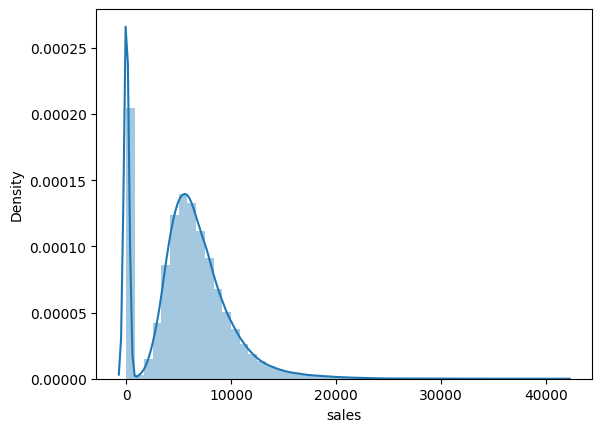

In [ ]:
sns.distplot(df1['sales'])

<ipython-input-32-984ac31c864c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

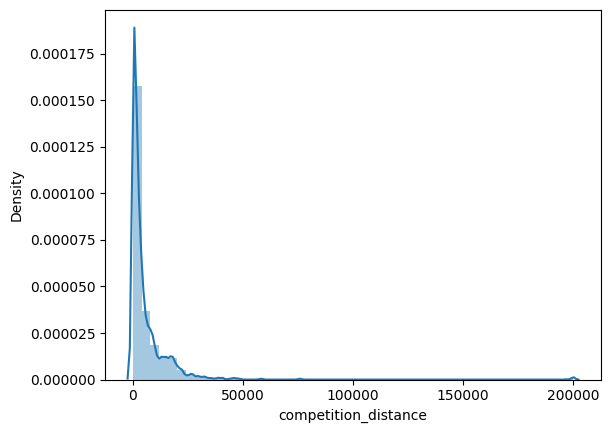

In [ ]:
sns.distplot(df1['competition_distance'])

###1.7 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


<Axes: xlabel='state_holiday', ylabel='sales'>

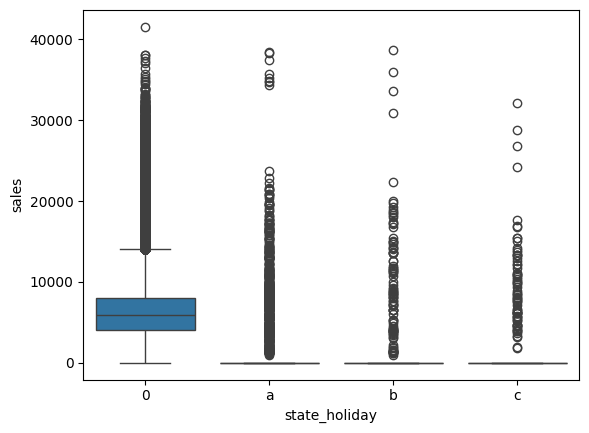

In [ ]:
sns.boxplot(x='state_holiday', y='sales', data=df1)

<Axes: xlabel='assortment', ylabel='sales'>

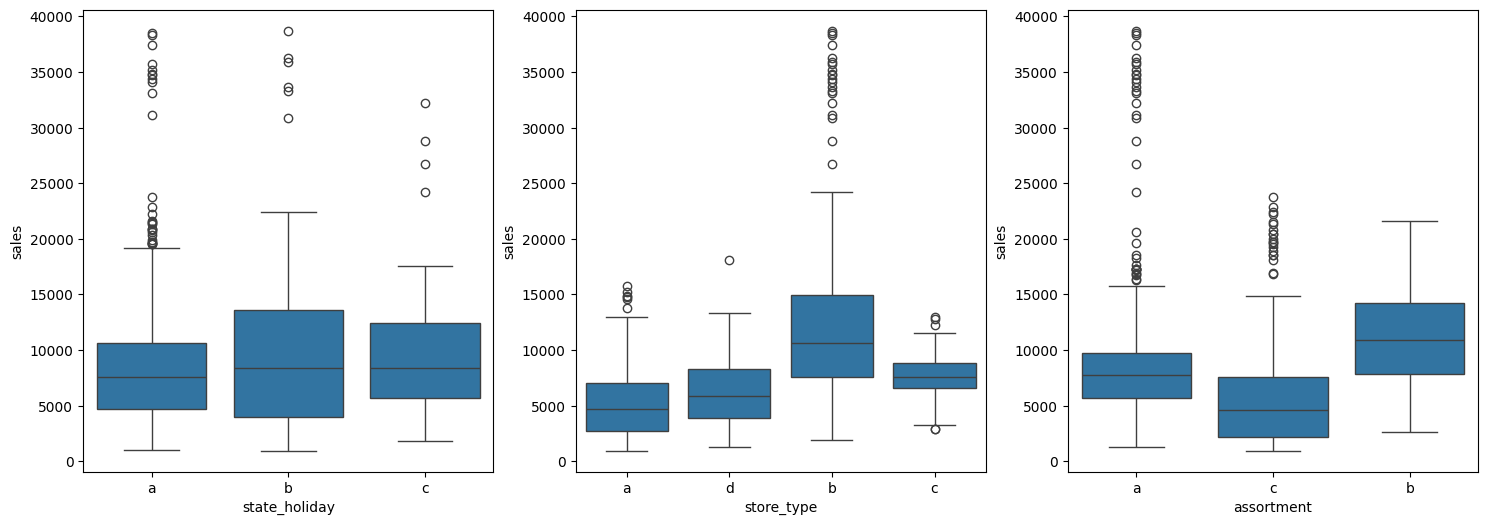

In [20]:
#filtering data considerating sales = 0 - stores closed

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])

sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])

sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])

#3.0 Feature Enginnering

In [21]:
df2 = df1.copy()

###3.1 Mind Map Hypotesis

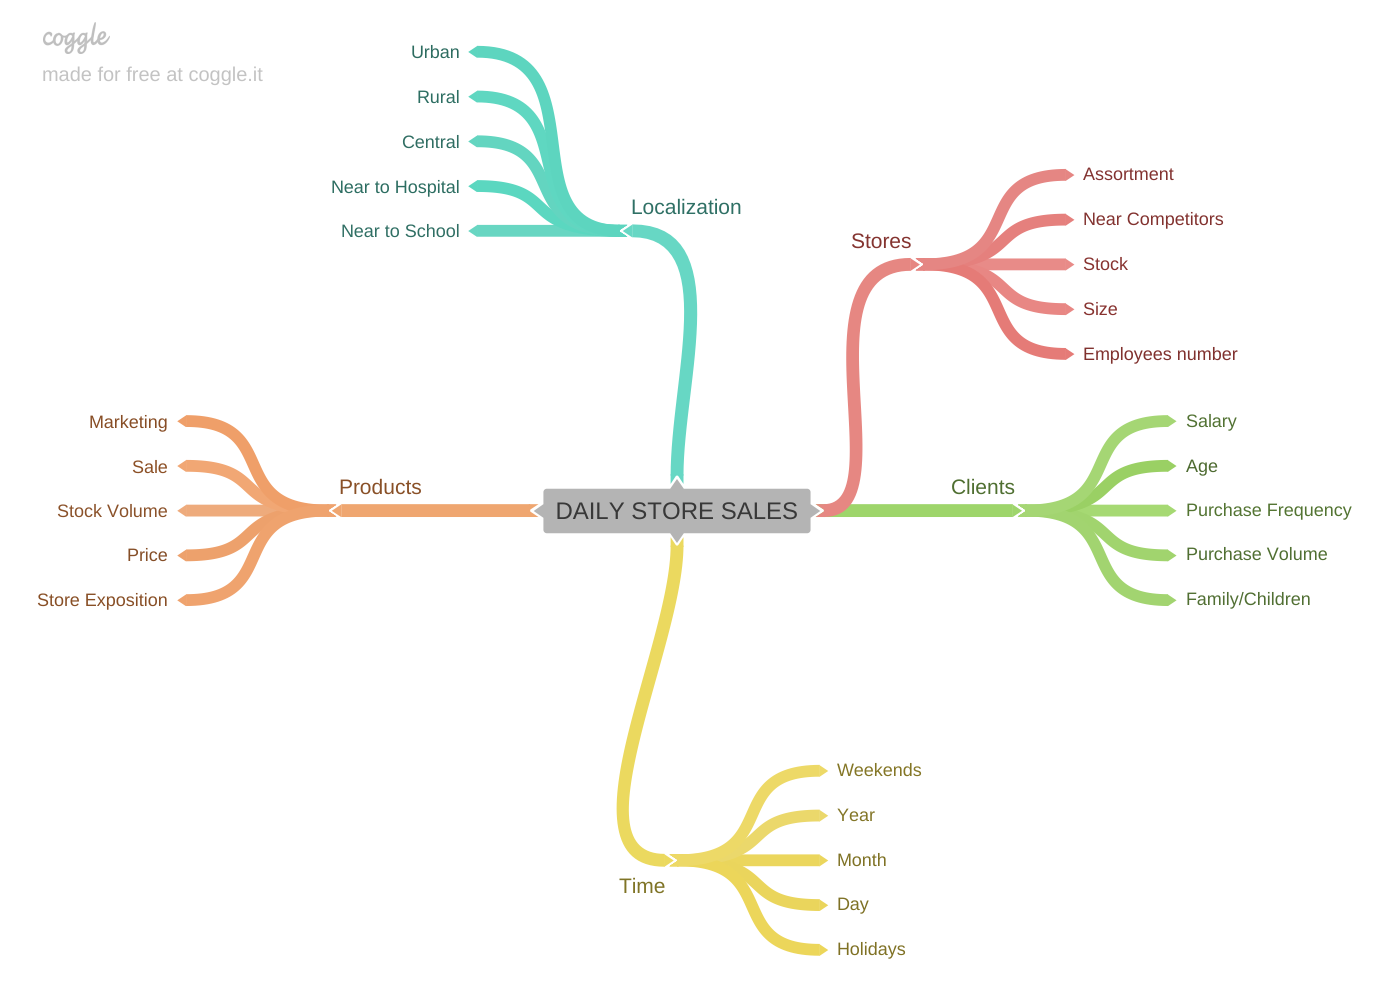

In [ ]:
Image('/content/DAILY_STORE_SALES.png')

###3.2 Hypotesis Creation

####3.2.1 Store Hypotesis

**1.** Stores with more employees should sell more.

**2.** Stores with bigger stock should sell more.

**3.** Bigger stores should sell more.

**4.** Smaller stores should sell less.

**5.** Stores with more assortment should sell more.

**6.** Stores that have been with competitors for longer should sell more.

####3.2.1 Product Hypotesis

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with more product exposition on vitrines should sell more.

**3.** Stores with cheaper products should sell more.

**4.** Stores with cheaper products for longer periods should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

####3.2.1 Time Hypotesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

###3.3 Variable Creation

In [28]:
#creating variables from date

#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#creating variables from competition column

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
#df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / np.timedelta64(1, 'm')).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = (((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int))

#changing variables

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


###3.4 Row Filtering

In [30]:
df3 = df2.copy()

In [32]:
# considering that closed stores dont have sales
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

###3.4 Column Selection

In [33]:
# removing column 'costumer' - because we dont know the number of future constumers, column 'open' - because it dont give useful information and another support columns
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)